# Validation Set 3 general validation

In [1]:
import os
import time

import itertools
from collections import defaultdict


from openpyxl import load_workbook
import networkx as nx

##### PyBEL imports

In [2]:
import pybel
import pybel_tools as pbt

from pybel import BELGraph
from pybel.constants import RELATION, ANNOTATIONS
from pybel.dsl import Abundance, BiologicalProcess, CentralDogma, ListAbundance, Reaction
from pybel.struct import get_subgraph_by_annotation_value
from pybel.struct.summary import count_functions

import matplotlib.pyplot as plt
from pybel_tools.summary import plot_summary, count_top_centrality

pybel.get_version()

'0.13.2'

##### PathMe import 

In [3]:
from pathme.constants import REACTOME_BEL, KEGG_BEL, WIKIPATHWAYS_BEL, PATHME_DIR
from pathme.export_utils import to_gml

##### DiffuPath import 

In [4]:
from diffupath.constants import DATA_DIR
from diffupath.validation_datasets_parsers import parse_set3

from diffupath.pathme_importer import get_labels_by_db_and_omic_from_pathme, get_labels_by_db_and_omic_from_graph
from diffupath.input_mapping import get_mapping, get_mapping_subsets, get_mapping_two_dim_subsets
from diffupath.utils import print_dict_dimensions, get_labels_set_from_dict, reduce_dict_dimension, get_count_and_labels_from_two_dim_dict, from_pickle, to_pickle, get_three_venn_intersections, random_disjoint_intersection_three_subsets
from diffupath.views import show_heatmap, show_venn_diagram

from diffupy.kernels import regularised_laplacian_kernel

## 1. Load Data Set 1: Input Scores

In [6]:
dataset3_labels_by_omics = parse_set3(os.path.join(DATA_DIR, 'validation_datasets', 'set3.xlsx'))
dataset3_all_labels = get_labels_set_from_dict(dataset3_labels_by_omics)
print_dict_dimensions(dataset3_labels_by_omics, 'Dataset3 imported labels:')

Total number of genes: 4941  
Total number of micrornas: 100  
Total number of metabolite: 21  
Total: 5062 


In [7]:
mirnas_dataset =  dataset3_labels_by_omics['micrornas']

## 2. Load Backrgound Graph Universe

### 2.1. PathMeUniverse import

In [7]:
pathme_universe_graph_no_flatten = pybel.from_pickle(os.path.join(DATA_DIR, 'pickles', 'universe', 'pathme_universe_bel_graph.bel.pickle'))


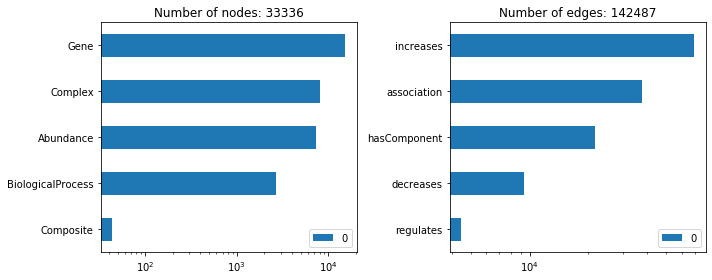

PathMe Universe v1.0.0
Number of Nodes: 33336
Number of Edges: 142487
Number of Citations: 6974
Number of Authors: 0
Network Density: 1.28E-04
Number of Components: 7284
Number of Warnings: 0


Counter({'Gene': 15186,
         'Abundance': 7292,
         'BiologicalProcess': 2679,
         'Composite': 44,
         'Complex': 8135})

In [8]:
plot_summary(pathme_universe_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

pathme_universe_graph_no_flatten.summarize()
count_functions(pathme_universe_graph_no_flatten)

##### Check isolates / Unconnected nodes

In [9]:
nx.number_of_isolates(pathme_universe_graph_no_flatten)

6858

In [10]:
pathme_universe_graph_no_flatten.remove_nodes_from({
    node
    for node in nx.isolates(pathme_universe_graph_no_flatten)
})

In [11]:
nx.number_of_isolates(pathme_universe_graph_no_flatten)

0

### 2.2. Get labels subsets by entity type (omic) and database

#####  From PathMeUniverse Graph Subsets

In [15]:
bg_labels_from_pathmeuniverse_by_db_and_omic, bg_labels_from_pathmeuniverse_by_omic_and_db =  get_labels_by_db_and_omic_from_graph(pathme_universe_graph_no_flatten)

print_dict_dimensions(bg_labels_from_pathmeuniverse_by_db_and_omic, 'Entities in PathMeUniverse :')

Total number of wikipathways: gene_nodes(2242), mirna_nodes(91), metabolite_nodes(575), bp_nodes(134),  
Total number of kegg: gene_nodes(5885), mirna_nodes(122), metabolite_nodes(1759), bp_nodes(112),  
Total number of reactome: gene_nodes(8431), mirna_nodes(13), metabolite_nodes(2595), bp_nodes(0),  
Total: 21959 


In [16]:
bg_labels_from_pathmeuniverse_by_omic = reduce_dict_dimension(bg_labels_from_pathmeuniverse_by_omic_and_db)

### 2.3. Get Background  Matrix Kernel

##### Generate kernel OR load from pickle

DiffuPy to generate laplacian_kernel

In [17]:
kernel_path = os.path.join(DATA_DIR, 'kernels', 'regularized_kernel_pathme_universe.pickle')

In [18]:
then = time.time()

In [19]:
#TODO: change kegg_pathme_graph_no_flatten to pathme_universe_graph_no_flatten
background_mat = regularised_laplacian_kernel(kegg_pathme_graph_no_flatten)

/Users/Projects/MultiPath/diffuPy/src/diffupy/utils.py:20: UserWarning:

Since graph is directed, it will be converted to an undirected graph.



Import kernel from pickle

In [23]:
#import pickle
#input_path = os.path.join(DATA_DIR, 'kernels', 'regularized_kernel_pathme_universe.pickle')

#with open(input_path, 'rb') as f:
#    unpickler = pickle.Unpickler(f)
#    background_mat = unpickler.load()

In [24]:
now = time.time()
print("It took: ", now-then, " seconds")

It took:  183.01916313171387  seconds


## 3. Dataset label mapping to PathMeEntities

##### All kernel matrix (background network) row labels for the mapping

In [25]:
background_labels = background_mat.rows_labels

### 3.1. General mapping

In [26]:
all_labels_mapping = get_mapping(dataset3_all_labels, background_labels, title = 'Global mapping: ', mirnas = mirnas_dataset, print_percentage = True)


Global mapping:  (1605) 31.706835242986962%


### 3.2. Mapping by subsets

#### 3.2.1. Mapping by entity type/omic

In [31]:
mapping_by_entity, _, _ = get_mapping_subsets(dataset3_labels_by_omics, background_labels, 'entity type/omic', mirnas=mirnas_dataset)


Mapping by entity type/omic:
genes (1597) 32.32139243068205%
micrornas (14) 14.000000000000002%
metabolite (8) 38.095238095238095%
Total (1619) 31.983405768470963% 



In [32]:
micrornas_mapping = mapping_by_entity['micrornas'][0]
micrornas_mapping

{'mir106b',
 'mir15a',
 'mir17',
 'mir183',
 'mir193b',
 'mir21',
 'mir222',
 'mir30b',
 'mir30d',
 'mir30e',
 'mir31',
 'mir32',
 'mir331',
 'mir34a'}

#### 3.2.2. Mapping by database

In [35]:
background_entites_by_db = {db : set(itertools.chain.from_iterable(entities.values())) for db, entities in bg_labels_from_pathmeuniverse_by_db_and_omic.items()}
mapping_by_db, _, _ = get_mapping_subsets(background_entites_by_db, dataset3_all_labels, 'database', mirnas=mirnas_dataset, submapping = background_labels, mirnas_mapping = micrornas_mapping, percentage_reference_labels = True)


Mapping by database:
wikipathways (500) 9.877518767285657%
kegg (1619) 31.983405768470963%
reactome (606) 11.971552745950218%
Total (1619) 31.983405768470963% 



#### 3.2.3. Mapping by entity type and database (two dimentions)

In [36]:
mapping_by_database_and_entity, total_percentage, total_dimention = get_mapping_two_dim_subsets(bg_labels_from_pathmeuniverse_by_db_and_omic, dataset3_all_labels, relative_statistics = dataset3_labels_by_omics, mirnas_mapping = micrornas_mapping)


Mapping by Wikipathways:
gene_nodes (665) 13.458814005262093%
mirna_nodes (9) 9.0%
metabolite_nodes (19) 90.47619047619048%
bp_nodes (0) 0%
Total (692) 22.763157894736842% 

Mapping by Kegg:
gene_nodes (1597) 32.32139243068205%
mirna_nodes (14) 14.000000000000002%
metabolite_nodes (8) 38.095238095238095%
bp_nodes (0) 0%
Total (1619) 20.55090124397055% 

Mapping by Reactome:
gene_nodes (1221) 24.711596842744385%
mirna_nodes (2) 2.0%
metabolite_nodes (12) 57.14285714285714%
bp_nodes (0) 0%
Total (1233) 11.183673469387754% 

Total (2376) 46.93796918214145% 



### 3.3. Mapping descriptive view

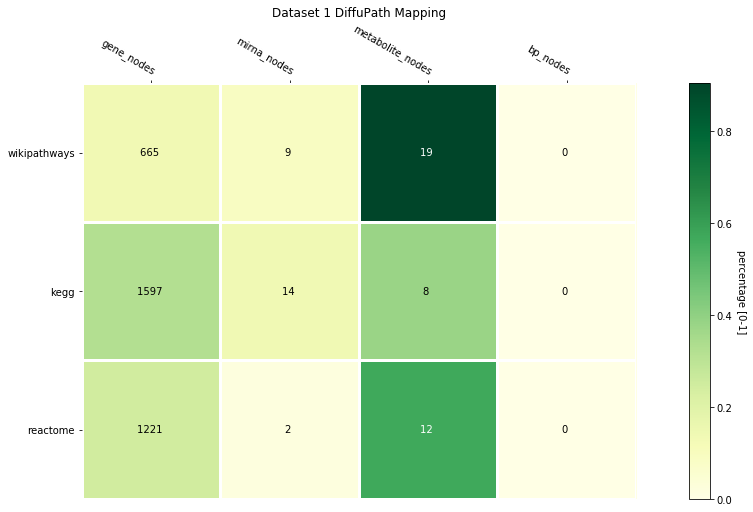

In [37]:
count, percentage, db_labels, entity_labels  = get_count_and_labels_from_two_dim_dict(mapping_by_database_and_entity)

show_heatmap(count, percentage, db_labels, entity_labels)


### 3.4. Overlap view

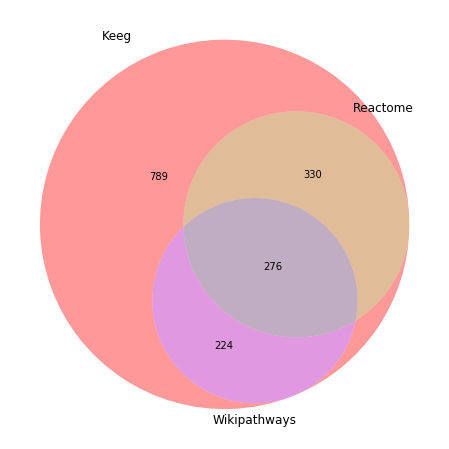

In [38]:
db_intersections = get_three_venn_intersections(mapping_by_db['kegg'][0], mapping_by_db['reactome'][0], mapping_by_db['wikipathways'][0])

show_venn_diagram(db_intersections)


### 3.5. Database disjoint

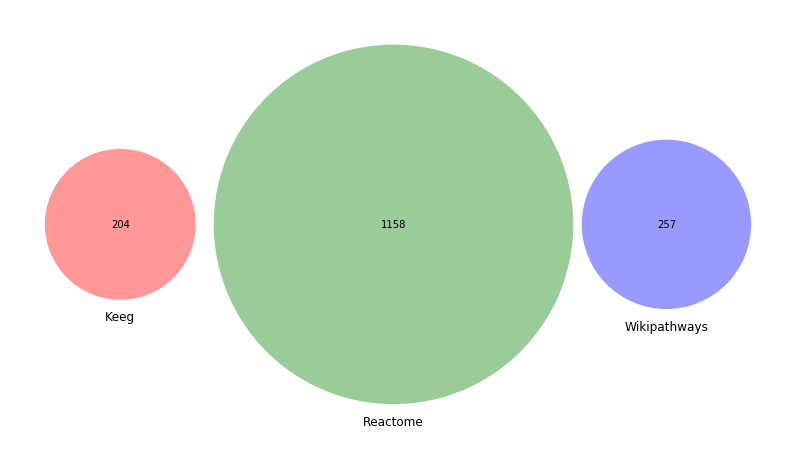

In [39]:
disjoint_db_mapping = random_disjoint_intersection_three_subsets(mapping_by_db)

show_venn_diagram(get_three_venn_intersections(*list(disjoint_db_mapping.values())))

## 4. Cross-validation

In [40]:
from diffupath.views import box_plot_from_dict
from diffupath.cross_validation import cross_validation_by_method

In [41]:
results_path = os.path.join(DATA_DIR, 'outputs', 'by_method_and_db_validation')

### 4.1. Random Scheme

In [42]:
auroc_metrics_by_method, auprc_metrics_by_method = cross_validation_by_method(all_labels_mapping, pathme_universe_graph_no_flatten, background_mat, k = 50)


  0%|          | 0/50 [00:00<?, ?it/s]


ValueError: Found input variables with inconsistent numbers of samples: [7916, 25685]

In [ ]:
box_plot_from_dict(auroc_metrics_by_method, 'Random Cross Validation', 'Method type', 'AUROC')

In [ ]:
box_plot_from_dict(auprc_metrics_by_method, 'Random Cross Validation', 'Method type', 'AUPRC')

In [ ]:
import json

with open('metrics_set3_universe.txt', 'w') as outfile:  
    json.dump({'auroc_metrics_by_method': auroc_metrics_by_method, 'auprc_metrics_by_method': auprc_metrics_by_method}, outfile)

    